In [0]:
# RESTART KERNEL AFTER RUNNING THIS CELL
!pip install pandas --upgrade

    100% |████████████████████████████████| 10.1MB 938kB/s 
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [0]:
# IMPORT MODULES
import pandas as pd
import numpy as np 
import scipy
import re
import ast
import pickle
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist, cosine
import time
import multiprocessing
from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier

**Group By Day By Industry and Generate Standardise Features**

In [0]:
combined_df = pd.read_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/combined.p')
industry_df = pd.read_csv('/content/drive/My Drive/BT4222 Group/workspace/data/IndustryData.csv')
df = combined_df.merge(industry_df, on = "assetCode")


### REMOVED ROWS WITH NULL INDUSTRY VALUES
df = df[pd.notnull(df['Industry'])]

In [0]:
def generate_columns_features(df, columns):
  
  # GROUPING
  grouped = df.groupby(columns)
  
  # STANDARDISATION PER GROUP
  score = lambda x: (x - x.mean()) / x.std()
  standard_df = grouped.transform(score)
  standard_df = standard_df.add_suffix('_stan')
  
  df = pd.concat([df, standard_df], axis = 1)
  return df

In [0]:
%%time
columns = ['time', 'Industry']
new_df = generate_columns_features(df, columns)

In [0]:
new_df.to_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/new_df.p')

**For Each Asset Code Take Average of Word Vectors**

In [0]:
# df has multiple columns of wv, has assetCode, and has Industry
def mean_wv_by_assetCode(df):
  
  # group according to asset code
  grouped = df.groupby('assetCode')
  
  # then find the mean of the word vectors # this forms a dataframe with all the mean_word_vectors
  mean_wv_df = grouped[wv_names].transform('mean')
  
  # concatenate the dataframe with the asset code and industry so that the mean are identifiable
  # mean_wv_df = pd.concat([df[['assetCode', 'Industry']], mean_wv_df], axis = 1)
  mean_wv_df['assetCode'] = df_a['assetCode'].tolist()
  mean_wv_df['Industry'] = df_a['Industry'].tolist()
  
  # remove duplicated rows, there would be many
  mean_wv_df = mean_wv_df.drop_duplicates()

In [0]:
combined_df = pd.read_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/combined_with_features_full_5yr.p')
industry_df = pd.read_csv('/content/drive/My Drive/BT4222 Group/workspace/data/IndustryData.csv')
df = combined_df.merge(industry_df, on = "assetCode")

mean_wv_df = mean_wv_by_assetCode(df)

In [0]:
mean_wv_df.to_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/mean_wv_df.csv')

**Generate Clusters**

In [0]:
def best_k_clustering(y, X):
  
  #######
  # SVD #
  #######

  svd_transformer = TruncatedSVD(n_components = 8)
  X_embedded = svd_transformer.fit_transform(X)
  
  # %%time

  models = {}

  cluster_range = range(2, 21)


  for k in cluster_range:
      kmeans_model = KMeans(n_clusters=k)
      kmeans_model.fit_transform(X_embedded)
      models[k] = kmeans_model
  
  # %%time

  scores_list = []

  for k in cluster_range:
      model = models[k]
      score = silhouette_score(X_embedded, model.labels_)
      scores_list.append(score)

  # plt.figure(figsize=(16,4))
  # plt.plot(scores_list)
  # plt.xticks(range(len(cluster_range)), cluster_range)
  # plt.ylabel('Mean Sample Silhouette Score')
  # plt.xlabel('k')
  # plt.title('Silhouette Plot')
  # plt.show()
  # plt.close()
  
  cluster = models[scores_list.index(max(scores_list)) + 2].labels_
  
  return cluster

In [0]:
mean_wv_df = pd.read_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/mean_wv_df.csv')
y = mean_wv_df['Industry']
X = mean_wv_df.drop(['assetCode','Industry'], axis=1)
cluster = best_k_clustering(y, X)

In [0]:
mean_wv_df['Cluster'] = cluster
cluster_df = mean_wv_df[['assetCode', 'Cluster']]

**Group By Day By Cluster  and Generate Standardise Features**

In [0]:
combined_df = pd.read_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/combined.p')
# cluster_df = pd.read_csv('/content/drive/My Drive/BT4222 Group/workspace/data/Cluster.csv')
df = combined_df.merge(cluster_df, on = "assetCode")

In [0]:
%%time
columns = ['time', 'Cluster']
new_df = generate_columns_features(df, columns)

In [0]:
new_df.to_pickle('/content/drive/My Drive/BT4222 Group/workspace/data/new_df.p')

### Wrapper for V3 Model

In [0]:
# df has multiple columns of wv, has assetCode
def mean_wv_by_assetCode(df, wv_names):
  
  # group according to asset code
  grouped = df.groupby('assetCode')
  
  # then find the mean of the word vectors # this forms a dataframe with all the mean_word_vectors
  mean_wv_df = grouped[wv_names].transform('mean')
  
  # concatenate the dataframe with the asset code and industry so that the mean are identifiable
  # mean_wv_df = pd.concat([df[['assetCode', 'Industry']], mean_wv_df], axis = 1)
  mean_wv_df['assetCode'] = df_a['assetCode'].tolist()
  
  # remove duplicated rows, there would be many
  mean_wv_df = mean_wv_df.drop_duplicates()


def best_k_clustering(X):
  
  #######
  # SVD #
  #######

  svd_transformer = TruncatedSVD(n_components = 8)
  X_embedded = svd_transformer.fit_transform(X)
  
  # %%time

  models = {}

  cluster_range = range(2, 21)


  for k in cluster_range:
      kmeans_model = KMeans(n_clusters=k)
      kmeans_model.fit_transform(X_embedded)
      models[k] = kmeans_model
  
  # %%time

  scores_list = []

  for k in cluster_range:
      model = models[k]
      score = silhouette_score(X_embedded, model.labels_)
      scores_list.append(score)
  
  best_model = models[scores_list.index(max(scores_list)) + 2]
  cluster_labels = best_model.labels_
  
  return cluster_labels, (best_model, svd_transformer)


def generate_columns_features(df, columns):
  
  grouped = df.groupby(columns)
  
  score = lambda x: (x - x.mean()) / x.std()
  standard_df = grouped.transform(score)
  standard_df = standard_df.add_suffix('_stan')
  
  df = pd.concat([df, standard_df], axis = 1)
  return df
  
  
def get_v3_train_test(train_word2vec, test_word2vec, wv_names):
  """
    train_word2vec and test_word2vec contain original data combined with added
    word2vec data for train and extracted word2vec data for test (validation)
  """
  global mean_wv_df, best_model, train_cluster_neut, test_cluster_neut
  mean_wv_df = mean_wv_by_assetCode(train_word2vec)
  _, (best_model, svd_transformer) = best_k_clustering(mean_wv_df)
  train_word2vec['Cluster'] = best_model.predict(svd_transformer.transform(train_data[wv_names]))
  test_word2vec['Cluster'] = best_model.predict(svd_transformer.transform(test_data[wv_names]))
  
  columns = ['time', 'Cluster']
  train_cluster_neut = generate_columns_features(train_word2vec, columns)
  test_cluster_neut = generate_columns_features(test_word2vec, columns)
  
  return train_cluster_neut, test_cluster_neut

In [0]:
%%time

v_str = 'v3'

file_counter = 1

train_end_years = [2011, 2012, 2013, 2014, 2015]

lstm_features_list = [
    'returnsClosePrevRaw1',
    'returnsOpenPrevRaw1',
    'returnsClosePrevMktres1',
    'returnsOpenPrevMktres1',
    'returnsClosePrevRaw10',
    'returnsOpenPrevRaw10',
    'returnsClosePrevMktres10',
    'returnsOpenPrevMktres10',
    'open_close',
    'oc_average',
    'turnover',
    'open_close_relative',
    'turnover_relative',
    'volume_relative',
    'returnsOpenPrevMktres1_relative',
    'returnsOpenPrevMktres10_relative',
]


additional_features_list = [
    'urgency_min',
    'urgency_count',
    'takeSequence_min',
    'takeSequence_max',
    'bodySize_mean',
    'wordCount_mean',
    'sentenceCount_mean',
    'companyCount_mean',
    'marketCommentary_mean',
    'relevance_mean',
    'sentimentNegative_mean',
    'sentimentNeutral_mean',
    'sentimentPositive_mean',
    'sentimentWordCount_mean',
    'noveltyCount12H_mean',
    'noveltyCount24H_mean',
    'noveltyCount3D_mean',
    'noveltyCount5D_mean',
    'noveltyCount7D_mean',
    'volumeCounts12H_mean',
    'volumeCounts24H_mean',
    'volumeCounts3D_mean',
    'volumeCounts5D_mean',
    'volumeCounts7D_mean',
]

label_encoded_features = [
    'dayofweek',
    'month',
]

continuous_features_list = lstm_features_list + additional_features_list
features_list = lstm_features_list + additional_features_list + label_encoded_features

for train_end_year in train_end_years:
  # a trick to get testing stats
  if train_end_year == 2016:
    train_end_year = 2015
    train_start, train_end = pd.to_datetime('2011-01-01'), pd.to_datetime('2016-06-30')
    test_start, test_end = pd.to_datetime('%d-07-01' % (train_end_year + 1)), pd.to_datetime('%d-12-31' % (train_end_year + 1))
    train_end_year = 2016
  else:
    train_start, train_end = pd.to_datetime('2011-01-01'), pd.to_datetime('%d-12-31' % train_end_year)
    test_start, test_end = pd.to_datetime('%d-01-01' % (train_end_year + 1)), pd.to_datetime('%d-06-30' % (train_end_year + 1))
  
  
  # divide into train and test periods

  train_data = combined_data.set_index('time')[train_start: train_end]
  test_data = combined_data.set_index('time')[test_start: test_end]

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  train_data[continuous_features_list] = scaler.fit_transform(train_data[continuous_features_list])
  test_data[continuous_features_list] = scaler.transform(test_data[continuous_features_list])
  
  # get word2vec features
  def combine_with_word2vec_features(train_df, word2vec_features_filepath): #train_df is the training df, word2vec_features is the word2vec_features filepath(load data from /content/drive/My Drive/BT4222 Group/workspace/FILENAME)
    start_time = time.time()

    word2vec_features = pd.read_csv(word2vec_features_filepath,header=None) #read the file
    header_list = []
    for i in range(100):
        header_list.append("word2vec" + str(i+1))
    word2vec_features.columns = header_list #set column names
    word2vec_features["all"] = word2vec_features.values.tolist() #create column with all the values combined as list
    
    word2vec_features = shape_wv(word2vec_features, train_start, train_end, original_combined_df, industry_df)
    
    train_df = train_df.reset_index() #reset indexes for both train and word2vec feature df
    word2vec_features = word2vec_features.reset_index()

    train_df["word2vec_features"] = word2vec_features["all"] #put the combined list values into train df
    train_df = train_df.set_index('time') #set index as time again
    
    print(train_df.shape)

    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

    return train_df

  start, end = 2011, min(train_end_year, 2015)
  word2vec_features_path = "./Data/new_features_full_%d_%d_%dyr_word2vec.csv" % (start, end, end - start + 1)
  word2vec_model_path = "./Data/new_full_%d_%d_%dyr_word2vec.wv" % (start, end, end - start + 1)
  train_data = combine_with_word2vec_features(train_data, word2vec_features_path)
  print("imhere")

  word2vec_df = pd.DataFrame(train_data['word2vec_features'].tolist())
  word2vec_df.index = train_data.index
  word2vec_df.columns = ['word2vec_%d' % i for i in range(word2vec_df.shape[1])]

  train_data = pd.concat([train_data.iloc[:, :-1], word2vec_df], axis=1)

  # get test data word vectors
  stop_words = stopwords.words('english')

  test_data['headline'] = test_data['headline'].fillna("")
  test_data_words = []

  for headline in test_data['headline']:
    words = [word.lower() for word in word_tokenize(headline) if word.isalpha()]
    words = [word for word in words if not word in stop_words]
    test_data_words.append(words)


  # get features
  def get_features_from_word2vec(word2vec, headline_list, feature_size):
    start_time = time.time()

    features = [] # Each feature is a 1x100 vector
    word_not_in_vocabulary = []

    for words in headline_list:
        feature = np.zeros(feature_size)
        for word in words:
            try:
              feature += word2vec.wv.get_vector(word)
            except:
              continue
              #word_not_in_vocabulary.append(word)
        features.append((feature / float(len(words))).tolist())

    no_nans_feature_list = list(filter(lambda x: np.isnan(x).any() == False, features))
    transposed = zip(*no_nans_feature_list)
    avg = lambda items: float(sum(items))/ len(items)
    average_vector = list(map(avg, transposed)) #this average vector will be used to replace all nan vectors

    features = np.array(list(map(lambda x: x if np.isnan(x).any() == False else average_vector, features)), dtype='float16').tolist()

    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    return features

  word2vec_model = Word2Vec.load(word2vec_model_path)
  test_word2vec_features = get_features_from_word2vec(word2vec_model, test_data_words, 100)
#   word2vec_df_test = pd.DataFrame(test_word2vec_features)
#   word2vec_df_test.columns = ['word2vec_%d' % i for i in range(word2vec_df_test.shape[1])]
#   word2vec_df_test.index = test_data.index
#   test_data = pd.concat((test_data, word2vec_df_test), axis=1)

  word2vec_df_test = pd.DataFrame(test_word2vec_features)
  word2vec_df_test.columns = ['word2vec_%d' % i for i in range(word2vec_df_test.shape[1])]
  word2vec_df_test.index = test_data.index
  test_data = pd.concat((test_data, word2vec_df_test), axis=1)

  # get word2vec feature names
  word2vec_features_list = []
  for col in train_data.columns:
    if 'word2vec' in col:
      word2vec_features_list.append(col)
    
  #### insert wrapper code ####  
  
  # df has multiple columns of wv, has assetCode
  def mean_wv_by_assetCode(df, wv_names):

    # group according to asset code
    grouped = df.groupby('assetCode')

    # then find the mean of the word vectors # this forms a dataframe with all the mean_word_vectors
    mean_wv_df = grouped[wv_names].transform('mean')

    # concatenate the dataframe with the asset code and industry so that the mean are identifiable
    # mean_wv_df = pd.concat([df[['assetCode', 'Industry']], mean_wv_df], axis = 1)
    mean_wv_df['assetCode'] = df['assetCode'].tolist()

    # remove duplicated rows, there would be many
    mean_wv_df = mean_wv_df.drop_duplicates()


  def best_k_clustering(X):

    #######
    # SVD #
    #######

    svd_transformer = TruncatedSVD(n_components = 8)
    svd_mat = svd_transformer.fit_transform(X)

    ########
    # TSNE #
    ########

    tsne_transformer = TSNE(n_components = 2)
    X_embedded = tsne_transformer.fit_transform(svd_mat)

    # %%time

    models = {}

    cluster_range = range(2, 21)


    for k in cluster_range:
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit_transform(X_embedded)
        models[k] = kmeans_model

    # %%time

    scores_list = []

    for k in cluster_range:
        model = models[k]
        score = silhouette_score(X_embedded, model.labels_)
        scores_list.append(score)

    best_model = models[scores_list.index(max(scores_list)) + 2]
    cluster_labels = best_model.labels_

    return cluster_labels, best_model


  def generate_columns_features(df, columns):

    grouped = df.groupby(columns)

    score = lambda x: (x - x.mean()) / x.std()
    standard_df = grouped.transform(score)
    standard_df = standard_df.add_suffix('_stan')

    df = pd.concat([df, standard_df], axis = 1)
    return df


  def get_v3_train_test(train_word2vec, test_word2vec, wv_names):
    """
      train_word2vec and test_word2vec contain original data combined with added
      word2vec data for train and extracted word2vec data for test (validation)
    """
    global mean_wv_df, best_model, train_cluster_neut, test_cluster_neut
    mean_wv_df = mean_wv_by_assetCode(train_word2vec)
    _, best_model = best_k_clustering(mean_wv_df)
    train_word2vec['Cluster'] = best_model.predict(train_data[wv_names])
    test_word2vec['Cluster'] = best_model.predict(test_data[wv_names])

    columns = ['time', 'Cluster']
    train_cluster_neut = generate_columns_features(train_word2vec, columns)
    test_cluster_neut = generate_columns_features(test_word2vec, columns)

    return train_cluster_neut, test_cluster_neut
  
  train_cluster_standardised, test_cluster_standardised = get_v3_train_test(train_data, test_data, word2vec_features_list)
  
  train_cluster_standardised_filename = 'train_cluster_standardised_' + str(file_counter)
  fileobj = open(train_cluster_standardised_filename, "wb")
  pickle.dump(train_cluster_standardised, fileobj)
  fileobj.close()
  
  test_cluster_standardised_filename = 'test_cluster_standardised_' + str(file_counter)
  fileobj = open(test_cluster_standardised_filename, "wb")
  pickle.dump(test_cluster_standardised, fileobj)
  fileobj.close()
  
  file_counter += 1




**Attempt to Predict Cells Where Industry is Null**

In [0]:
def fill_null(df, predict_column, features, model, tsne_comp):
  
  df_notnull = df[pd.notnull(df[predict_column])]
  
  X = df_notnull.drop(['Industry', 'assetCode'], axis=1)
  y = df_notnull[predict_column]
  
  #######
  # SVD #
  #######
  
  svd_transformer = TruncatedSVD(n_components = 8)
  svd_mat = svd_transformer.fit_transform(X)
  
  ########
  # TSNE #
  ########
  
  tsne_transformer = TSNE(n_components = tsne_comp)
  X_embedded = tsne_transformer.fit_transform(svd_mat)
  
  ################
  # Graph Output #
  ################
  
  categories = np.array(y)

  plt.figure(figsize=(16,8))

  categories_number = len(set(categories))
  cmap_name = 'tab20'
  colors = [cm.get_cmap(cmap_name)(i / float(categories_number - 1)) for i in range(categories_number)]


  for i, category in enumerate(set(categories)):
    filtered_mat = X_embedded[categories == category]
    plt.scatter(filtered_mat[:, 0], filtered_mat[:, 1], s=10, label=category, c=colors[i])
    
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.18), ncol=5, fancybox=True, shadow=True)
  plt.show()
  plt.close()
  
  ################################################
  # split X and y into training and testing sets #
  ################################################
  
  X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, random_state=1)
  
  ########################
  # K Nearest Neighbours #
  ########################
  
  if model == "KNN":
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
  
  #################
  # Random Forest #
  #################
  
  else:
    
    # Instantiate model with 1000 decision trees
    model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    model.fit(X_train, y_train);
    
    # require(randomForest)
    # model = randomForest(X_train,factor(y_train),X_test,factor(y_test), ntree=500, proximity = True, importance = True, keep.forest = True, do.trace = True)
  
  #####################
  # Predict Test Data #
  #####################
  
  test_results = model.predict(X_test)
  
  ######################
  # Predict Train Data #
  ######################
  train_results  = model.predict(X_train)

  ########################
  # Performance Matrices #
  ########################
  
  confusion_matrix = metrics.confusion_matrix(y_test, test_results)
  print('Confusion Matrix of Test Data', confusion_matrix)
  test_accuracy = metrics.accuracy_score(y_test, test_results)
  print('Testing Accuracy', test_accuracy)
  # test_precision = metrics.precision_score(y_test, test_results)
  # print('Testing Precision', test_precision)
  # test_f1 = metrics.f1_score(y_test, test_results)
  # print('Testing F1 Score: ', test_f1)

  train_accuracy  = metrics.accuracy_score(y_train, train_results)
  print('Training Accuracy', train_accuracy)
    
    


Result for Model 1 using KNN



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

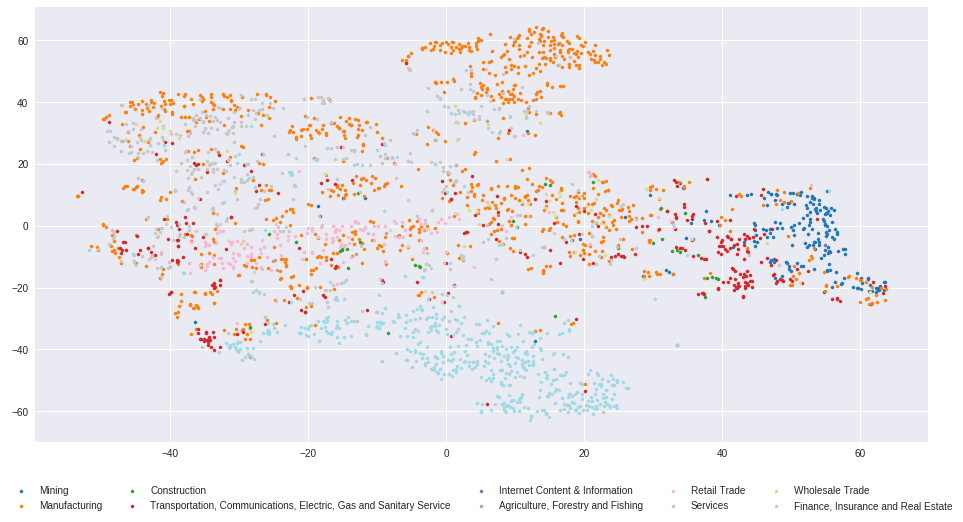

Confusion Matrix of Test Data [[  0   0   0   0   0   0   0   0   0]
 [  0   1   1   4   0   0   0   3   0]
 [  0   0 104   5   1   0  13   3   0]
 [  2   2   4 196  11   7  26   1   2]
 [  0   0   1   8  31   0   0   3   0]
 [  0   0   0  18   1  24   4   1   1]
 [  0   0  13  39   0   1  50   8   0]
 [  0   0   3  15   4   0   8  36   0]
 [  0   0   1   8   2   2   2   0   0]]
Testing Accuracy 0.6597014925373135
Training Accuracy 0.7605774016923843


In [0]:
# KNN
print("Result for Model using KNN\n")
fill_null(mean_wv_df, 'Industry', wv_names, 'KNN', 2)

Result for Model 1 using RF



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

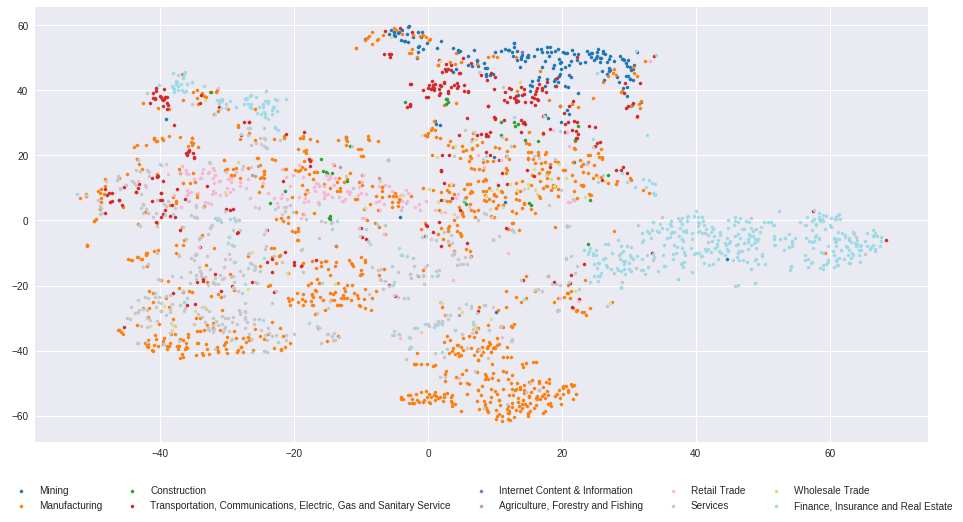

Confusion Matrix of Test Data [[  0   0   0   0   0   0   0   0   0]
 [  0   2   1   3   0   0   1   2   0]
 [  0   0  99   6   1   1  16   3   0]
 [  0   2   2 182  11  12  29  10   3]
 [  0   0   1   7  30   0   0   5   0]
 [  0   0   1  13   0  28   4   1   2]
 [  1   0   9  38   0   0  55   7   1]
 [  0   0   3  11   5   1   7  39   0]
 [  0   0   1  10   2   1   1   0   0]]
Testing Accuracy 0.6492537313432836
Training Accuracy 1.0


In [0]:
# RF
print("Result for Model using RF\n")
fill_null(mean_wv_df, 'Industry', wv_names, 'RF', 2)